# Microsoft Film Studio Project Submission

By,
Matt Schwartz

9/28/20 Part-Time Data Science Cohort


## Introduction

Microsoft has decided to enter the movie business but where to start? Microsoft is already well integrated in millions of homes across the country with its Office software in virtually every PC. The company also maintains a vast entertainment business with Xbox and its associated game studio. 

To diversify its offerings in the entertainment space, it makes sense to enter the filmmaking industry. As streaming grows and traditional TV viewing shrinks, platforms are starved for any content they can get their hands on. Microsoft can further expand its market share by becoming a content provider. Their films can start in theaters, and then be pushed to its Xbox service, or any others who are interested in its productions.

The following Jupyter notebook provides data and insights on the film industry by exploring what success looks like, and what areas are worth pursuing.

At the end, I will provide recommendations to the head of Microsoft's new movie studio about what types of films to create.

## Approach

I used four main data sources to conduct my analysis of the film industry. These were:

* IMDB Basics (basics_df) - Contained titles, production year, runtime, and genres, as well as a unique IMDB ID
* IMDB Ratings (ratings_df) - Contained the unique IMDB ID, average rating given by IMDB users, and the number of votes the movie received on the site
* Gross revenues from *Box Office Mojo* (gross_df) - Contained the movie title, movie studio, production year, and domestic and foreign gross revenues
* Movie Budgets from *The Numbers* (budgets_df) - Contained the movie title, production budget, domestic and worldwide gross revenues, production year

I go on to combine these data sets, which I'll explain further down, so I can calculate how ratings and revenues are correlated, what genres are the most highly rated, and what movies have the best returns on their investment, along with other types of analysis.

What I focus on are the big, franchise tentpole-style movies. The kinds that everyone talks about and feels the need to go see, from Star Wars to Marvel movies. Microsoft has a market capitalization of over $1 trillion, which puts it right along side Apple, Amazon, and Alphabet. Microsoft can take big swings - the company is nearly 5 times as valuable as Disney, one of it's main competitors in this space - because of a near unlimited amount of capital. Big budget productions are riskier, but have the highest reward. Microsoft will presumably want to attack this market, and put out films that will get more people interested in Microsoft products and entertainment, from Xbox and its video games, to its laptops.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Upload Data (Gross Budgets, IMDB Basics data, IMDB Ratings)
 Perform necessary cleanup

In [2]:
#gross revenues (includes year and studio) and clean up of null values
gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')

#fill foreign gross nulls with 0s - these likely just didn't have worldwide releases
gross_df['foreign_gross'].fillna(value = '0', inplace = True)

#convert foreign gross to float from string
gross_df.dropna(inplace = True)
gross_df['foreign_gross'] = gross_df['foreign_gross'].str.replace(',', '')
gross_df['foreign_gross'] = gross_df['foreign_gross'].astype('float64')
gross_df['total_rev'] = gross_df['domestic_gross'] + gross_df['foreign_gross']
gross_df['total_rev'] = gross_df['total_rev'].astype('int64')
gross_df.dropna(inplace = True)

#drop data from India for studio analysis
gross_df.drop(gross_df[gross_df['studio'] == 'HC'].index, inplace = True)
gross_df.drop(gross_df[gross_df['studio'] == 'GrtIndia'].index, inplace = True)

#imdb basics data
basics_df = pd.read_csv('zippedData/imdb.title.basics.csv.gz')

#No need for movies slated for production after 2020
basics_df.drop(basics_df[basics_df['start_year'] >= 2020].index, inplace = True)
basics_df.dropna(inplace = True)
basics_df.drop(columns = 'original_title', inplace = True)


#dropping dupes and any title with parentheses in them
basics_df.drop_duplicates(subset = ['primary_title'], inplace = True)
df = basics_df[~basics_df.primary_title.str.contains('\)')]
display(df.info())

#imdb ratings data
ratings_df = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
ratings_df.dropna(inplace = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104858 entries, 0 to 146139
Data columns (total 5 columns):
tconst             104858 non-null object
primary_title      104858 non-null object
start_year         104858 non-null int64
runtime_minutes    104858 non-null float64
genres             104858 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 4.8+ MB


None

In [3]:
df.head()

,tconst,primary_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama
4,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy"
5,tt0111414,A Thin Life,2018,75.0,Comedy


In [4]:
ratings_df.head()

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [5]:
gross_df.head()

,title,studio,domestic_gross,foreign_gross,year,total_rev
0,Toy Story 3,BV,415000000.0,652000000.0,2010,1067000000
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1025500000
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,960300000
3,Inception,WB,292600000.0,535700000.0,2010,828300000
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,752600000


In [6]:
gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3354 entries, 0 to 3386
Data columns (total 6 columns):
title             3354 non-null object
studio            3354 non-null object
domestic_gross    3354 non-null float64
foreign_gross     3354 non-null float64
year              3354 non-null int64
total_rev         3354 non-null int64
dtypes: float64(2), int64(2), object(2)
memory usage: 183.4+ KB


### Let's see the number of movies made per year

[Text(0, 0.5, 'movies made'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, '# of movies per year')]

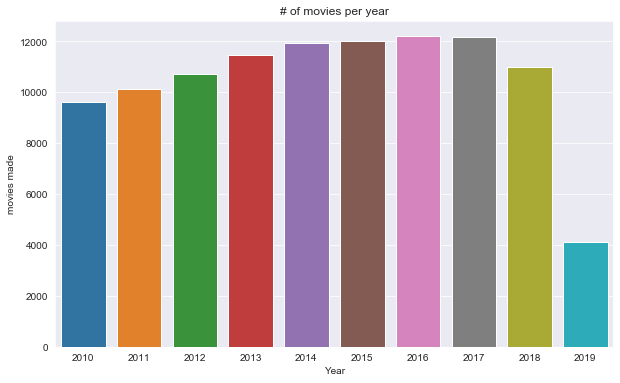

In [7]:
sns.set_style('darkgrid')
plt.figure(figsize = (10,6))
movies_year_df = basics_df.groupby('start_year')['primary_title'].count()

x = movies_year_df.index
y = movies_year_df.values

bar_plot = sns.barplot(x, y)
bar_plot.set(xlabel = 'Year', ylabel = 'movies made',
                                    title = '# of movies per year')

Note that this data is only partially complete as it was downloaded in 2019. We can see however, a peak in 2016, with a drop off coming in 2018 and 2019

Now we'll combine basics with ratings - These should merge easily because of the unique ID, 'tconst'

In [8]:
#combine df with ratings 

#set index to tconst
df.set_index('tconst', inplace = True)
ratings_df.set_index('tconst', inplace = True)

#perform inner join
basics_and_ratings_df = df.join(ratings_df, how = 'inner')


#split genre string into list
basics_and_ratings_df['genres'] = basics_and_ratings_df['genres'].str.split(',')

#dropping all movies with less than 100 votes
basics_and_ratings_df.drop(basics_and_ratings_df[basics_and_ratings_df['numvotes'] < 100].index, inplace = True)

#rename some pesky star wars titles for later merges - these will be big revenue movies
#and we want to make sure they're preserved in the merge
basics_and_ratings_df['primary_title'].replace('Star Wars: Episode VII - The Force Awakens', 
                                               'Star Wars: The Force Awakens', inplace = True)


In [9]:
basics_and_ratings_df.head()

,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes
tconst,,,,,,
tt0069049,The Other Side of the Wind,2018,122.0,[Drama],6.9,4517
tt0100275,The Wandering Soap Opera,2017,80.0,"[Comedy, Drama, Fantasy]",6.5,119
tt0137204,Joe Finds Grace,2017,83.0,"[Adventure, Animation, Comedy]",8.1,263
tt0146592,Pál Adrienn,2010,136.0,[Drama],6.8,451
tt0162942,Children of the Green Dragon,2010,89.0,[Drama],6.9,120


In [10]:
basics_and_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25989 entries, tt0069049 to tt9914286
Data columns (total 6 columns):
primary_title      25989 non-null object
start_year         25989 non-null int64
runtime_minutes    25989 non-null float64
genres             25989 non-null object
averagerating      25989 non-null float64
numvotes           25989 non-null int64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.4+ MB


###  Before we move on, let's look at the ratings distribution

Text(0, 0.5, 'Frequency')

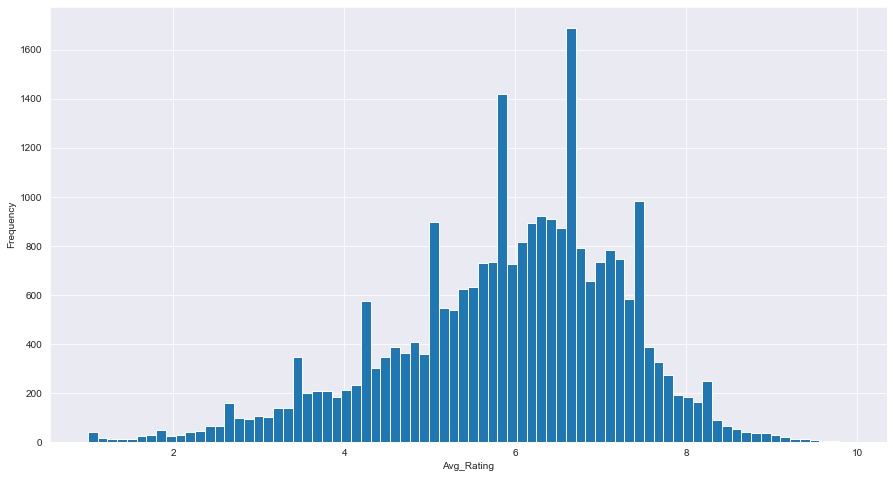

In [11]:
plt.figure(figsize = (15,8))
plt.hist(basics_and_ratings_df.averagerating, bins = 'auto')
plt.xlabel('Avg_Rating')
plt.ylabel('Frequency')

In [12]:
basics_and_ratings_df.averagerating.describe()

count    25989.000000
mean         5.918188
std          1.355169
min          1.000000
25%          5.200000
50%          6.100000
75%          6.900000
max          9.900000
Name: averagerating, dtype: float64

We see that the data is slightly left-skewed, with most of the movies rated between 5-8, and the mean at around 6. It appears difficult for any movie to receive an average rating beyond 7, which is reserved for movies like Inception and The Avengers.

### Now, let's start discovering trends by genre
Combining the basics and ratings data allow us to see the movie name, genre, year, and average rating side by side so we can perform some more in-depth analysis.

In [13]:
#first, some functions

def counting_values(df, column):
    """
    This function takes in a dataframe, and the column (as a string) you'd like to iterate through. 
    The column must contain lists. The keys in the value_count dictionary are the individual strings in the column lists.
    As it comes across elements in the list in each row for the first time, it adds the element as a key.
    As it goes through each row,  it adds 1 to that key:value pair when a repeat is discovered.
    df = dataframe
    column = dataframe column name, as a string
    """
    value_count = {}
    for row in df[column]:
        if len(row) > 0:
            for key in row:
                if key in value_count:
                    value_count[key] += 1
                else:
                    value_count[key] = 1
        else:
            pass
    return value_count

def sum_avg_rating(df, genre, genre_col, ratings_col):
    """
    This function takes in a dataframe, checks to see if a genre entered (as a string) shows up in the genre column (as a string). 
    If it does, it adds the rating in the ratings column, and adds 1 to the count variable. 
    It returns an average by dividing the total ratings by the count.
    df = dataframe
    genre = string value
    genre_col = dataframe column name, as a string
    ratings_col = dataframe column name, as a string
    """
    rating = 0
    count = 0
    for x in range(0, len(df)):
        if genre in df[genre_col][x]:
            rating += df[ratings_col][x]
            count += 1
    return rating/count

In [14]:
#function tests

print('Avg. Rating:', sum_avg_rating(basics_and_ratings_df, 'Documentary', 'genres', 'averagerating'))
counting_values(basics_and_ratings_df, 'genres')

Avg. Rating: 7.0888623469692575


{'Drama': 12361,
 'Comedy': 7811,
 'Fantasy': 939,
 'Adventure': 1844,
 'Animation': 827,
 'History': 939,
 'Action': 3628,
 'Biography': 1374,
 'Thriller': 3879,
 'Sci-Fi': 1058,
 'Crime': 2382,
 'Horror': 3168,
 'Mystery': 1413,
 'Romance': 3141,
 'Family': 1206,
 'War': 374,
 'Documentary': 3349,
 'Music': 663,
 'Sport': 463,
 'Western': 114,
 'Musical': 229,
 'News': 110,
 'Reality-TV': 1,
 'Game-Show': 1,
 'Adult': 1}

# Question 1: What movie genres do we see the most, and which are the most popular, by average rating?

Using the Counting Values function, lets chart the number of movies per genre since 2010

[Text(0, 0.5, '# of movies'),
 Text(0.5, 0, 'Genre'),
 Text(0.5, 1.0, '# of movies by genre')]

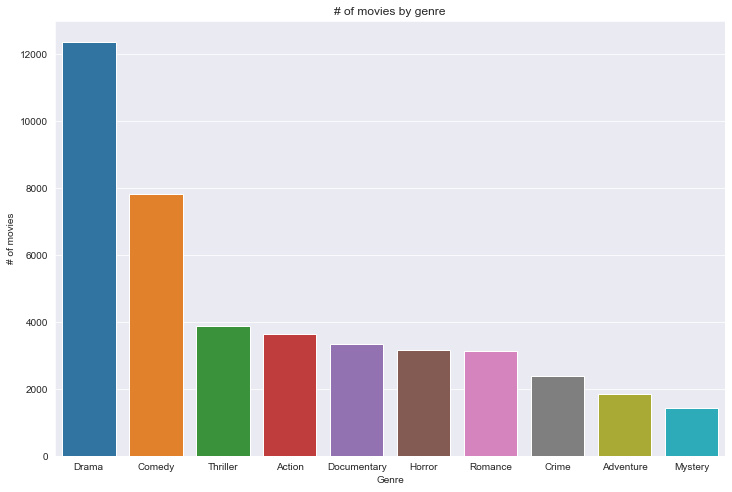

In [15]:
#first, create a pandas series out of the counting values function for easy graphing.
genres_count = pd.Series(counting_values(basics_and_ratings_df, 'genres'))
genres = genres_count.sort_values(ascending = False)

#Lets graph the top 10
genres = genres.head(10)

plt.figure(figsize = (12,8))
x = genres.index
y = genres.values

bar_plot = sns.barplot(x, y)
bar_plot.set(xlabel = 'Genre', ylabel = '# of movies',
                                    title = '# of movies by genre')

We see that dramas are by far, the most produced type of movie. Note that, because each movie may have more than one genre associated with it, the number of movies graphed may be more than the total number of movies in the data.

For our average ratings by genre calculations, let's create some for loops and dictionaries to easily iterate through the genres

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

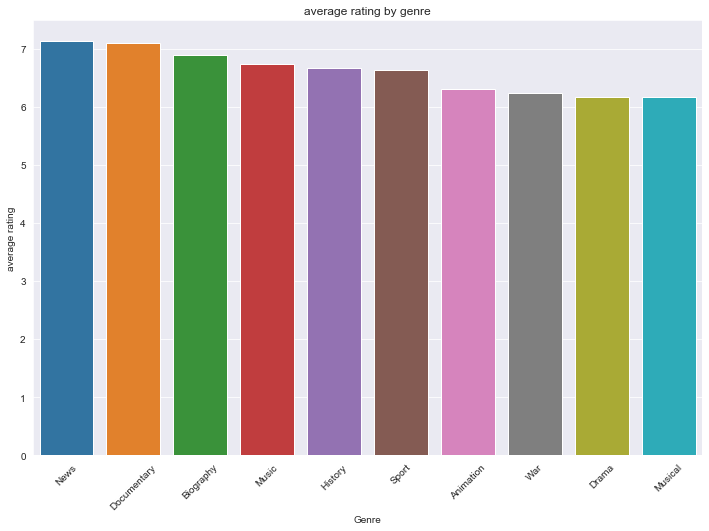

In [16]:
#create a list of unique genres to iterate through
genres_list = []
for row in basics_and_ratings_df.genres:
    for genre in row:
        genres_list.append(genre)
genre_list = list(set(genres_list))
genre_list

#create a dictionary, in which we'll insert key, value pairs by using the genres list in conjunction with the sum_avg_rating
#function. genres is the key, while the values are from sum_avg_rating function
#the dictionary will be used to plot data by converting to pandas series
dict_ratings = {}
for genres in genre_list:
    dict1 = {genres: sum_avg_rating(basics_and_ratings_df, genres, 'genres', 'averagerating')}
    dict_ratings.update(dict1)
    
#now convert our dictionary to a pandas' series
genres_rate = pd.Series(dict_ratings)
genres_rate = genres_rate.sort_values(ascending = False)
genres_rate.head(10)

#plot of average ratings for top 10 rated genres
genres_rate = genres_rate.head(10)
plt.figure(figsize = (12,8))
x = genres_rate.index
y = genres_rate.values

bar_plot = sns.barplot(x, y)
bar_plot.set(xlabel = 'Genre', ylabel = 'average rating',
                                    title = 'average rating by genre')
plt.xticks(rotation = 45)

This table shows the top 5 rated genres include news, documentaries, biographies, and sports. One theory is that, although news and documentaries can be biased either deliberately, or through the director's unconscious bias, it appears that movies mainly centered around fact-gathering have more universal approval. There are also less of these movies, meaning less people watch them, leading to fewer ratings. High ratings from fewer people will lead to highly rated movies.

It tracks that a documentary about economics, or nature, or a historical event would be met with less strong opinions than say, a comedy that falls flat or a boring action movie. Generally, people have fair expectations when viewing these films. Expectations are ratched up for big movies like Star Wars, and are met with polarizing reviews if it fails to live up to them.

## Question 2: What, if any, connection or correlation is there between production budgets, and a film's total gross revenue and its average rating?

####  Now for some further analysis, let's combine the budgets data with the basics and ratings data

In [17]:
#budgetary data (includes production budgets)
budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

#all financial numbers are strings, convert to foat
#remove $ and ',' from string so we can convert to float
budgets_df['production_budget'] = budgets_df['production_budget'].str.replace(',', '')
budgets_df['production_budget'] = budgets_df['production_budget'].str.replace('$', '')
budgets_df['domestic_gross'] = budgets_df['domestic_gross'].str.replace(',', '')
budgets_df['domestic_gross'] = budgets_df['domestic_gross'].str.replace('$', '')
budgets_df['worldwide_gross'] = budgets_df['worldwide_gross'].str.replace(',', '')
budgets_df['worldwide_gross'] = budgets_df['worldwide_gross'].str.replace('$', '')

#convert float
budgets_df['production_budget'] = budgets_df['production_budget'].astype('float64')
budgets_df['domestic_gross'] = budgets_df['domestic_gross'].astype('float64')
budgets_df['worldwide_gross'] = budgets_df['worldwide_gross'].astype('float64')

#convert gross and budget back to ints
budgets_df['worldwide_gross'] = budgets_df['worldwide_gross'].astype('int64')
budgets_df['production_budget'] = budgets_df['production_budget'].astype('int64')

#create profit column in budgets, change to ints
budgets_df['profit'] = (budgets_df['domestic_gross'] + budgets_df['worldwide_gross']) - budgets_df['production_budget']
budgets_df['profit'] = budgets_df['profit'].astype('int64')

#split the release date col into two columns, day and year - remove extra space from year, convert to int
budgets_df[['Day', 'Year']] = budgets_df.release_date.str.split(",",expand=True)
budgets_df['Year'] = budgets_df['Year'].str.replace(' ', '')
budgets_df['Year'] = budgets_df['Year'].astype('int64')

#create ROI col
budgets_df['ROI'] = budgets_df['profit']/budgets_df['production_budget']

#drop the day and release date columns as they are not necessary
budgets_df.drop(columns = 'Day', inplace = True)
budgets_df.drop(columns = 'release_date', inplace = True)

#set the index to id
budgets_df.set_index('id', inplace = True)
budgets_df.head()

#create a new dataframe for movies made in 2010 and later
budgets_2010s_df = budgets_df[(budgets_df['Year'] > 2010) & (budgets_df['Year'] < 2021)]


#clean up some other names
basics_and_ratings_df['primary_title'].replace('Star Wars: Episode VII - The Force Awakens', 'Star Wars: The Force Awakens', inplace = True)

#standardize star wars titles
budgets_2010s_df['movie'].replace('Star Wars Ep. VII: The Force Awakens', 'Star Wars: The Force Awakens', inplace = True)
budgets_2010s_df['movie'].replace('Star Wars Ep. VIII: The Last Jedi', 'Star Wars: The The Last Jedi', inplace = True)

C:\Users\mtsch\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [18]:
budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 7 columns):
movie                5782 non-null object
production_budget    5782 non-null int64
domestic_gross       5782 non-null float64
worldwide_gross      5782 non-null int64
profit               5782 non-null int64
Year                 5782 non-null int64
ROI                  5782 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 361.4+ KB


In [19]:
#combine budgets with basics and ratings 

#set index to movie
budgets_2010s_df.set_index('movie', inplace = True)
basics_and_ratings_df.set_index('primary_title', inplace = True)

#perform inner join
budget_ratings_df = basics_and_ratings_df.join(budgets_2010s_df, how = 'inner')

budget_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1483 entries, #Horror to xXx: Return of Xander Cage
Data columns (total 11 columns):
start_year           1483 non-null int64
runtime_minutes      1483 non-null float64
genres               1483 non-null object
averagerating        1483 non-null float64
numvotes             1483 non-null int64
production_budget    1483 non-null int64
domestic_gross       1483 non-null float64
worldwide_gross      1483 non-null int64
profit               1483 non-null int64
Year                 1483 non-null int64
ROI                  1483 non-null float64
dtypes: float64(4), int64(6), object(1)
memory usage: 139.0+ KB


Although the sample has now shrunk significantly from where it started, the data from nearly 1500 movies should be robust enough to track meaningful trends.

In [20]:
#reset index and rename movie title column

budget_ratings_df.reset_index(inplace = True)
budget_ratings_df.rename(columns = {'index':'movie'}, inplace = True)
budget_ratings_df.drop_duplicates(subset = 'movie', inplace = True)
budget_ratings_df.drop([0], inplace = True)

#add revenue col
budget_ratings_df['total_rev'] = budget_ratings_df['domestic_gross'] + budget_ratings_df['worldwide_gross']
budget_ratings_df.drop(columns = 'Year', inplace = True)
budget_ratings_df.reset_index(inplace = True)

In [21]:
budget_ratings_df.drop(columns = 'index', inplace = True)

Now we'll write a function to calculate the revenue by rating, as well as functions for budget and ROI

In [22]:
#these functions work just like the function used above for average ratings, but now use different columns
genres_list = []
for row in budget_ratings_df.genres:
    for genre in row:
        genres_list.append(genre)
genre_list = list(set(genres_list))
genre_list

def sum_avg_rev(df, genre, genre_col, rev_col):
    """
    This function takes in a dataframe, checks to see if a genre entered (as a string) shows up in the genre column (as a string). 
    If it does, it adds the revenue in the revenue column to the revenue variable, and adds 1 to the count variable. 
    It returns an average by dividing the total revenue by the count.
    df = dataframe
    genre = string value
    genre_col = dataframe column name, as a string
    rev_col = dataframe column name, as a string
    """
    revenue = 0
    count = 0
    for x in range(0, len(df)):
        if genre in df[genre_col][x]:
            revenue += df[rev_col][x]
            count += 1
    return revenue/count


def sum_avg_budget(df, genre, genre_col, budget_col):
    """
    This function takes in a dataframe, checks to see if a genre entered (as a string) shows up in the genre column (as a string). 
    If it does, it adds the budget in the budget column, and adds 1 to the count variable. 
    It returns an average by dividing the total budget by the count.
    df = dataframe
    genre = string value
    genre_col = dataframe column name, as a string
    budget_col = dataframe column name, as a string
    """
    budget = 0
    count = 0
    for x in range(0, len(df)):
        if genre in df[genre_col][x]:
            budget += df[budget_col][x]
            count += 1
    return budget/count

def sum_avg_roi(df, genre, genre_col, roi_col):
    """
    This function takes in a dataframe, checks to see if a genre entered (as a string) shows up in the genre column (as a string). 
    If it does, it adds the roi in the roi column, and adds 1 to the count variable. 
    It returns an average by dividing the total roi by the count.
    df = dataframe
    genre = string value
    genre_col = dataframe column name, as a string
    roi_col = dataframe column name, as a string
    """
    roi = 0
    count = 0
    for x in range(0, len(df)):
        if genre in df[genre_col][x]:
            roi += df[roi_col][x]
            count += 1
    return roi/count


#now lets create some dictionaries where genres is the key, the values are from running the functions

dict_rev = {}
for genres in genre_list:
    dict1 = {genres: sum_avg_rev(budget_ratings_df, genres, 'genres', 'total_rev')}
    dict_rev.update(dict1)

dict_budget = {}
for genres in genre_list:
    dict1 = {genres: sum_avg_budget(budget_ratings_df, genres, 'genres', 'production_budget')}
    dict_budget.update(dict1)

dict_roi = {}
for genres in genre_list:
    dict1 = {genres: sum_avg_roi(budget_ratings_df, genres, 'genres', 'ROI')}
    dict_roi.update(dict1)

#### First, we'll graph revenue by genre

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

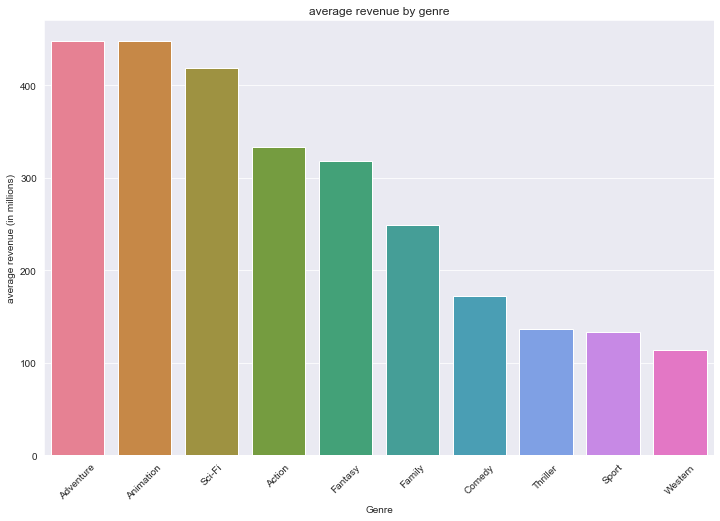

In [23]:
genres_rev = pd.Series(dict_rev)
genres_rev = genres_rev.sort_values(ascending = False)

genres_rev = genres_rev.head(10)
plt.figure(figsize = (12,8))
x = genres_rev.index
y = genres_rev.values/1000000

bar_plot = sns.barplot(x, y, palette = 'husl')
bar_plot.set(xlabel = 'Genre', ylabel = 'average revenue (in millions)',
                                    title = 'average revenue by genre')
plt.xticks(rotation = 45)

These results make sense logically. Adventure movies include those franchise tentpoles like Marvel films, Fast and the Furious, and Star Wars, while overlapping with the Sci-Fi genre. Animation will include movies like Toy Story, along with every other Disney Pixar movie and the Dreamworks catalog.

#### Average budget per genre

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

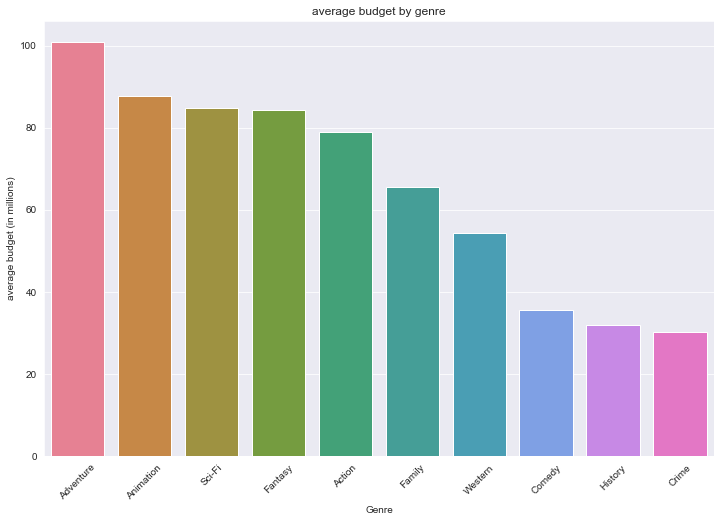

In [24]:
genres_budget = pd.Series(dict_budget)
genres_budget = genres_budget.sort_values(ascending = False)
genres_budget = genres_budget.head(10)

plt.figure(figsize = (12,8))
x = genres_budget.index
y = genres_budget.values/1000000

bar_plot = sns.barplot(x, y, palette = 'husl')
bar_plot.set(xlabel = 'Genre', ylabel = 'average budget (in millions)',
                                    title = 'average budget by genre')
plt.xticks(rotation = 45)

This is nearly the exact same genres in the top 10 as the previous group. The genres that cost the most to make also gross the most. And we see a clear correlation here with a coeffcient of .78:

In [25]:
df = pd.DataFrame(budget_ratings_df, columns = ['production_budget', 'total_rev'])
df.corr()

,production_budget,total_rev
production_budget,1.000000,0.782144
total_rev,0.782144,1.000000


We see below that there is a weaker, but still positive correlation between production budget and a movie's average rating. Further analysis could be useful to try to determine causation and weed out bias, and between production budgets and revenue. Based on the data we have here, it appears that production budget is a better predictor for revenue than it is for average rating.

In [26]:
df = pd.DataFrame(budget_ratings_df, columns = ['production_budget', 'averagerating'])
df.corr()

,production_budget,averagerating
production_budget,1.000000,0.226331
averagerating,0.226331,1.000000


#### Average ROI per genre

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

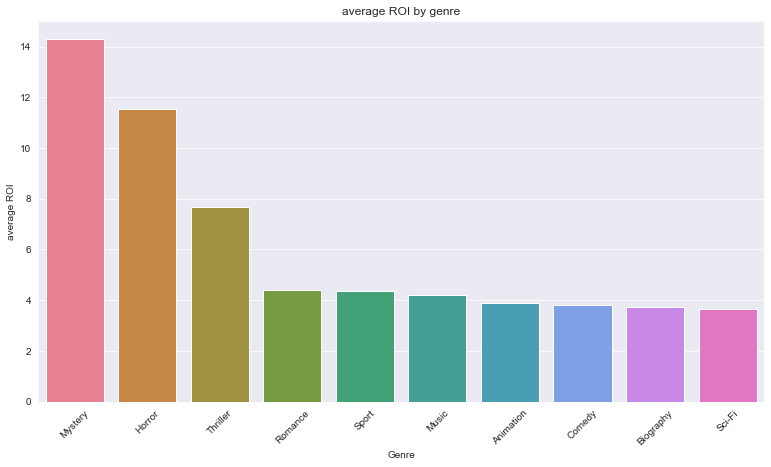

In [27]:
genres_roi = pd.Series(dict_roi)
genres_roi = genres_roi.sort_values(ascending = False)
genres_roi = genres_roi.head(10)

plt.figure(figsize = (13,7))
x = genres_roi.index
y = genres_roi.values

bar_plot = sns.barplot(x, y, palette = 'husl')
bar_plot.set(xlabel = 'Genre', ylabel = 'average ROI',
                                    title = 'average ROI by genre')
plt.xticks(rotation = 45)

Horror and Mystery movies (which overlap in our data), have far and away the best returns on their investments. These types of movies traditionally have lower budgets, but have the opportunity to become viral sensations, like Paranormal Activity or Get Out, which ended up winning Oscars. These films have much smaller productions in general, but although the ROIs are large, they still fall behind in revenues.

### Let's focus on budgets over the last 10 years more generally

In [28]:
budgets_2010s_df.reset_index(inplace = True)
budgets_2010s_df.head()

,movie,production_budget,domestic_gross,worldwide_gross,profit,Year,ROI
0,Pirates of the Caribbean: On Stranger Tides,410600000,241063875.0,1045663875,876127750,2011,2.133774
1,Dark Phoenix,350000000,42762350.0,149762350,-157475300,2019,-0.449929
2,Avengers: Age of Ultron,330600000,459005868.0,1403013963,1531419831,2015,4.632244
3,Star Wars: The The Last Jedi,317000000,620181382.0,1316721747,1619903129,2017,5.110105
4,Star Wars: The Force Awakens,306000000,936662225.0,2053311220,2683973445,2015,8.771155


#### First, revenue

C:\Users\mtsch\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

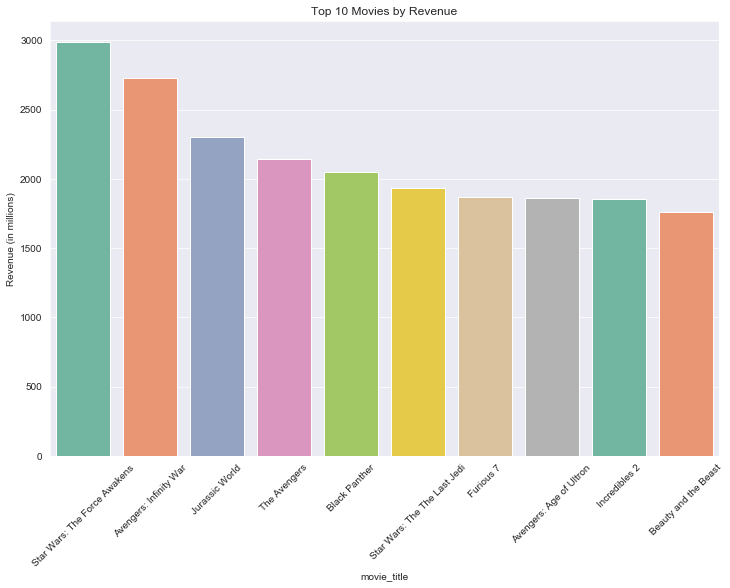

In [29]:
budgets_2010s_df['total_revenue'] = budgets_2010s_df['domestic_gross'] + budgets_2010s_df['worldwide_gross']
top_10_rev = budgets_2010s_df.sort_values('total_revenue',ascending=False)
top_10_rev = top_10_rev.head(10)

plt.figure(figsize = (12,8))

x = top_10_rev['movie']
y = top_10_rev['total_revenue']/1000000

bar_plot = sns.barplot(x, y, palette = 'Set2')
bar_plot.set(xlabel = 'movie_title', ylabel = 'Revenue (in millions)',
                                    title = 'Top 10 Movies by Revenue')
plt.xticks(rotation=45) 

All 10 of these movies are vast, well-known franchises, 8 out of 10 of which are produced by Disney (Star Wars, Marvel, Animated features). Gross revenues were well over $1 bilion for these 10. 

In [30]:
top_10_rev['production_budget'].mean()

#Avg budget is $244,360,000

244360000.0

## Question 3: What sort of connection do we see between ROI and revenue and ROI and average rating?
##### Alternatively, can revenue help predict average rating?

#### ROI

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

C:\Users\mtsch\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\mtsch\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\mtsch\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\mtsch\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0, flags=flags)


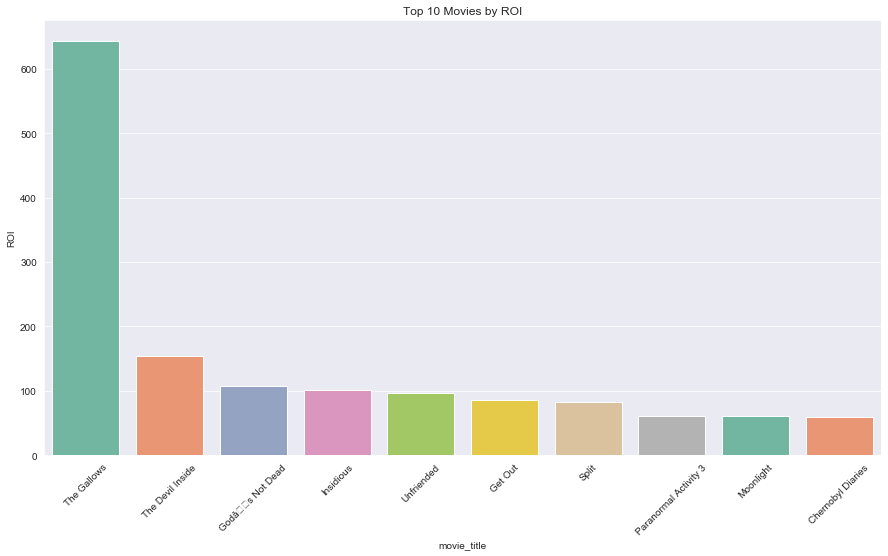

In [31]:
top_10_ROI = budgets_2010s_df.sort_values('ROI',ascending=False)
top_10_ROI = top_10_ROI.head(10)

plt.figure(figsize = (15,8))

x = top_10_ROI['movie']
y = top_10_ROI['ROI']

bar_plot = sns.barplot(x, y, palette = 'Set2')
bar_plot.set(xlabel = 'movie_title', ylabel = 'ROI',
                                    title = 'Top 10 Movies by ROI')
plt.xticks(rotation=45)

In [32]:
#lets find the average budget for the Top 10 movies by ROI

top_10_ROI['production_budget'].mean()

#Avg budget is $2,225,000 - extremely cheap

2225000.0

9 of the 10 movies with the highest ROI are low-budget horror films. These sorts of movies have smaller production demands, smaller casts, and need minimal investment to create scary movies.

However, these films obviously have lower revenues and profits then some of the big tent-pole movies. The average budget for the top 10 films in terms of revenue is nearly 100x more than these top movies by ROI.

Below we have the total revenues for these top 10 ROI films, and the total revenues for the top 10 movies by revenue overall.

,movie,production_budget,domestic_gross,worldwide_gross,profit,Year,ROI,total_revenue
1341,Get Out,5000000,176040665.0,255367951,426408616,2017,85.281723,431408616.0
1342,Split,5000000,138141585.0,278964806,412106391,2017,82.421278,417106391.0
1343,Paranormal Activity 3,5000000,104028807.0,207039844,306068651,2011,61.213730,311068651.0
1686,The Devil Inside,1000000,53262945.0,101759490,154022435,2012,154.022435,155022435.0
1628,Insidious,1500000,54009150.0,99870886,152380036,2011,101.586691,153880036.0


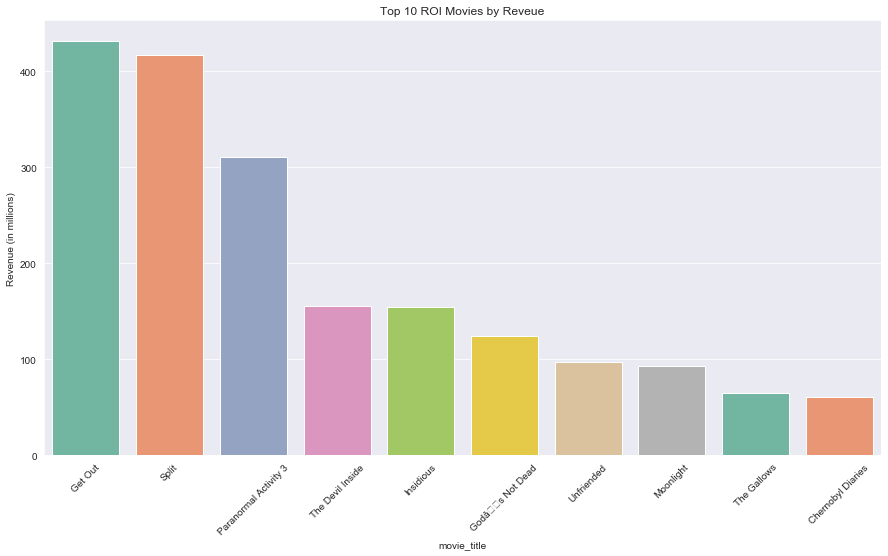

In [33]:
plt.figure(figsize = (15,8))

top_10_ROI['total_revenue'] = top_10_ROI['domestic_gross'] + top_10_ROI['worldwide_gross']
top_10_ROI = top_10_ROI.sort_values('total_revenue', ascending = False)

x = top_10_ROI['movie']
y = top_10_ROI['total_revenue']/1000000

bar_plot = sns.barplot(x, y, palette = 'Set2')
bar_plot.set(xlabel = 'movie_title', ylabel = 'Revenue (in millions)',
                                    title = 'Top 10 ROI Movies by Reveue')
plt.xticks(rotation=45)

top_10_ROI.head()

Get Out earned the most in this set, but still well below when the franchise films brought in.

### Now lets compare profit totals of the 2 sets of movies

,movie,production_budget,domestic_gross,worldwide_gross,profit,Year,ROI,total_revenue
1341,Get Out,5000000,176040665.0,255367951,426408616,2017,85.281723,431408616.0
1342,Split,5000000,138141585.0,278964806,412106391,2017,82.421278,417106391.0
1343,Paranormal Activity 3,5000000,104028807.0,207039844,306068651,2011,61.213730,311068651.0
1686,The Devil Inside,1000000,53262945.0,101759490,154022435,2012,154.022435,155022435.0
1628,Insidious,1500000,54009150.0,99870886,152380036,2011,101.586691,153880036.0


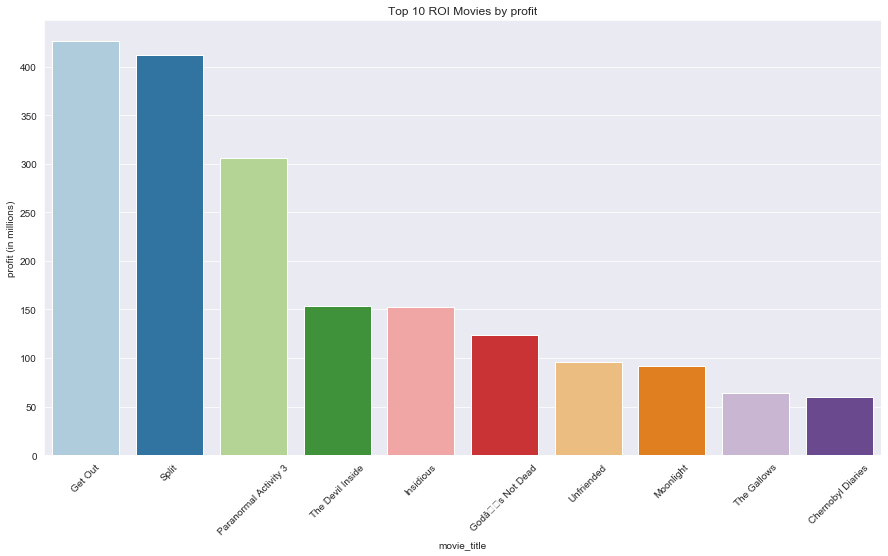

In [34]:
plt.figure(figsize = (15,8))

top_10_ROI = top_10_ROI.sort_values('profit', ascending = False)

x = top_10_ROI['movie']
y = top_10_ROI['profit']/1000000

bar_plot = sns.barplot(x, y, palette = 'Paired')
bar_plot.set(xlabel = 'movie_title', ylabel = 'profit (in millions)',
                                    title = 'Top 10 ROI Movies by profit')
plt.xticks(rotation=45)

top_10_ROI.head()

Since the production budgets for these films were so small, the profits they earned are very similar to gross revenues. Below, we'll compare these to the profits that the top 10 grossing films made.

,movie,production_budget,domestic_gross,worldwide_gross,profit,Year,ROI,total_revenue
4,Star Wars: The Force Awakens,306000000,936662225.0,2053311220,2683973445,2015,8.771155,2.989973e+09
5,Avengers: Infinity War,300000000,678815482.0,2048134200,2426949682,2018,8.089832,2.726950e+09
24,Jurassic World,215000000,652270625.0,1648854864,2086125489,2015,9.702909,2.301125e+09
19,The Avengers,225000000,623279547.0,1517935897,1916215444,2012,8.516513,2.141215e+09
27,Black Panther,200000000,700059566.0,1348258224,1848317790,2018,9.241589,2.048318e+09


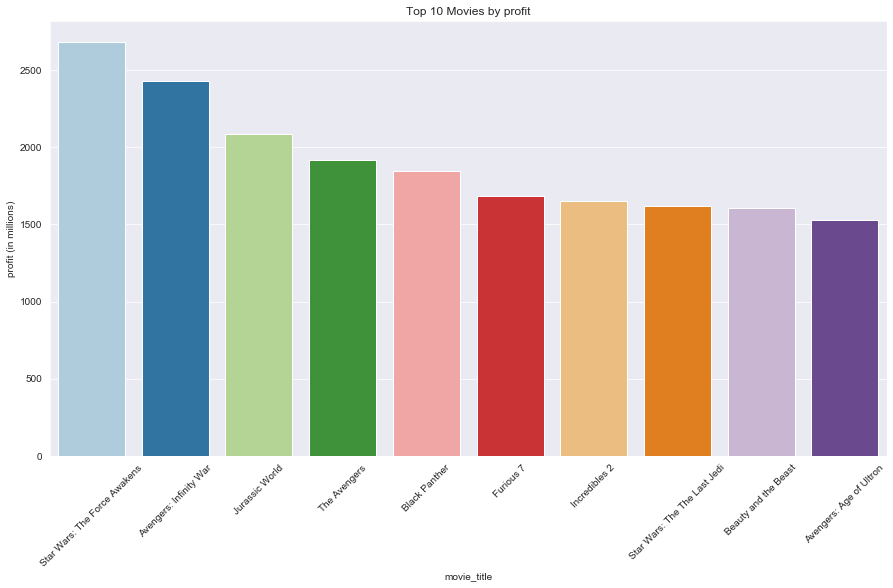

In [35]:
plt.figure(figsize = (15,8))
top_10_rev = top_10_rev.sort_values('profit', ascending = False)

x = top_10_rev['movie']
y = top_10_rev['profit']/1000000

bar_plot = sns.barplot(x, y, palette = 'Paired')
bar_plot.set(xlabel = 'movie_title', ylabel = 'profit (in millions)',
                                    title = 'Top 10 Movies by profit')
plt.xticks(rotation=45)

top_10_rev.head()

Even with vastly larger budgets and a lower ROI, these films still all brought in well over $1 billion.

### We'll now use both the ratings and budget data to figure out the ratings for the top ROI movies and the top grossing movies

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

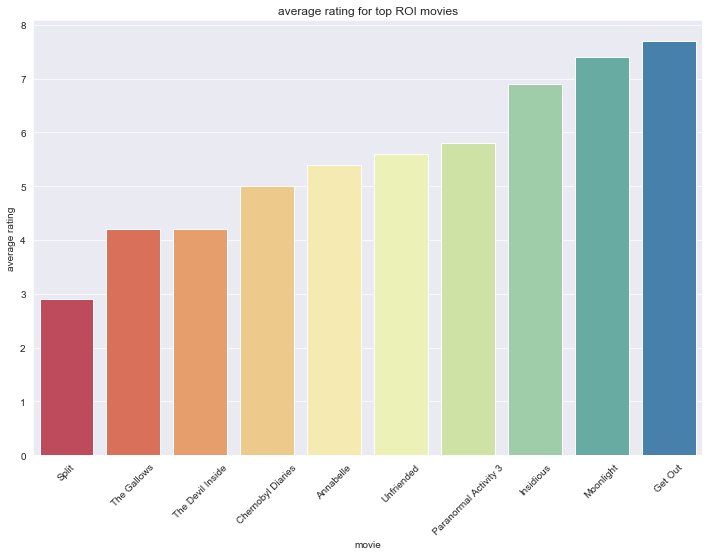

In [36]:
#drop films with a domestic gross of less than 2000, these are skewing the data downward somewhat and not relevant
#to our analysis
df = budget_ratings_df.drop(budget_ratings_df[budget_ratings_df['domestic_gross'] == 0].index)
df = df.drop(df[df['domestic_gross'] < 2000].index)
df = df.sort_values('ROI', ascending = False).head(10)


#chart of ratings for top 10 ROI movies
df = df.sort_values('averagerating')
plt.figure(figsize = (12,8))
x = df['movie']
y = df['averagerating']

bar_plot = sns.barplot(x, y, palette = 'Spectral')
bar_plot.set(xlabel = 'movie', ylabel = 'average rating',
                                    title = 'average rating for top ROI movies')
plt.xticks(rotation = 45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

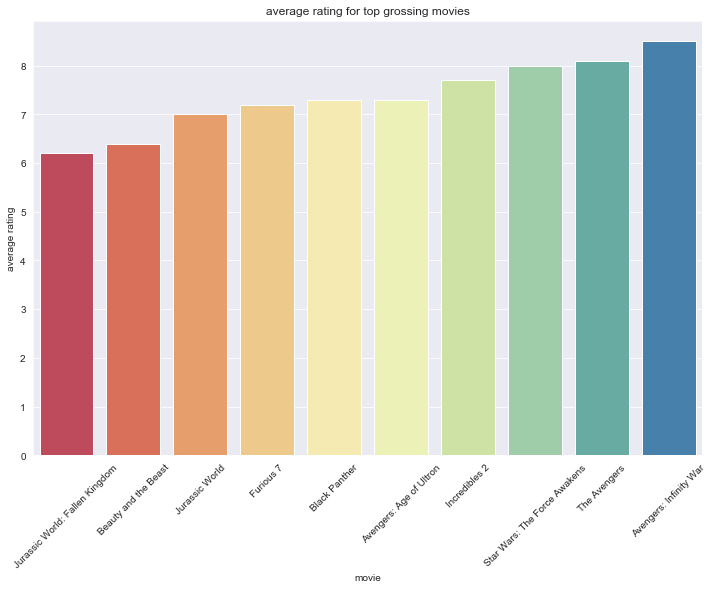

In [37]:
df = budget_ratings_df.drop(budget_ratings_df[budget_ratings_df['domestic_gross'] == 0].index)
df = df.drop(df[df['domestic_gross'] < 2000].index)

df = df.sort_values('total_rev', ascending = False).head(10)
df = df.sort_values('averagerating')
plt.figure(figsize = (12,8))
x = df['movie']
y = df['averagerating']

bar_plot = sns.barplot(x, y, palette = 'Spectral')
bar_plot.set(xlabel = 'movie', ylabel = 'average rating',
                                    title = 'average rating for top grossing movies')
plt.xticks(rotation = 45)

Comparing the two groups, we see that the top grossing movies have higher average ratings than the top ROI movies. This could simply be that these movies are fun, and the vast budgets ensure a higher floor in terms of quality. They may not blow you away, but will still be entertaining and visually stunning. Lower budget movies have more room for error, whether it's because of a lesser known cast, or poor direction, among other possible causes.

Below, we run some correlation calculations. We find that there is a strong, positive correlation between revenue and average rating. This makes sense, since a movie that has made a lot of money implies that people like it. Like before, further analysis would be useful to determine causality. Many more variables would need to be included to try to remove the bias from any regression results - there are likley many different reasons a movie's ratings are high, and it would seem unlikely that revenue would "cause" this, although we might see how average ratings could "cause" higher revenue.

In [38]:
df1 = pd.DataFrame(df, columns = ['total_rev', 'averagerating'])
df1.corr()

,total_rev,averagerating
total_rev,1.000000,0.699982
averagerating,0.699982,1.000000


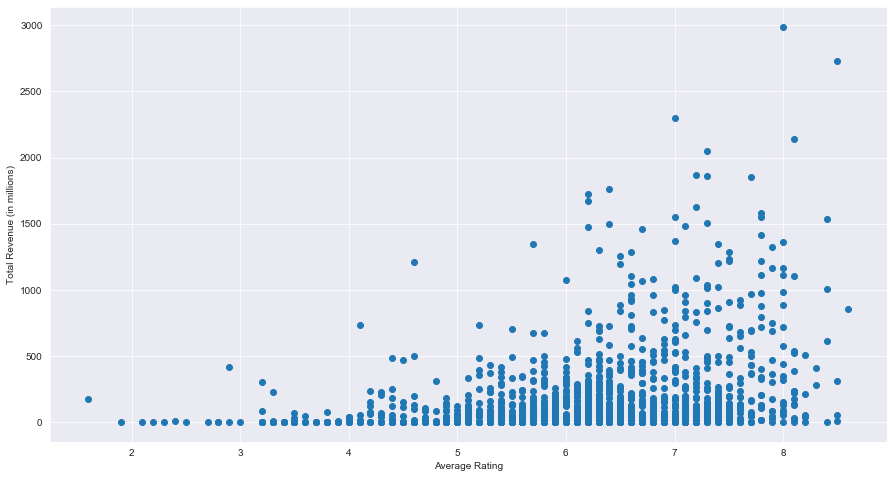

In [39]:
plt.figure(figsize = (15, 8))
x = budget_ratings_df['averagerating']
y = budget_ratings_df['total_rev']/1000000

plt.xlabel('Average Rating')
plt.ylabel('Total Revenue (in millions)')
plt.scatter(x, y)

In [40]:
df1 = pd.DataFrame(df, columns = ['ROI', 'averagerating'])
df1.corr()

,ROI,averagerating
ROI,1.000000,-0.292034
averagerating,-0.292034,1.000000


Interestingly enough, we see that ROI and average rating are negatively correlated. Once again, it seems unlikely one could possibly "cause" the other, but previous data exploration can help explain this correlation. We saw above that the average ratings for the top movies by ROI are much lower than the ratings for the top grossing movies. A majority of these are horror movies, which have a larger range in ratings, and tend to rate lower - tying back to the correlation between production budgets and average rating. This result shows us more than anything that a good return on a movie investment does not imply the movie is good, if "goodness" is defined by average rating in this case.

### What are the other top studios making in terms of average revenue?

Let's check out Microsoft's potential competition

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

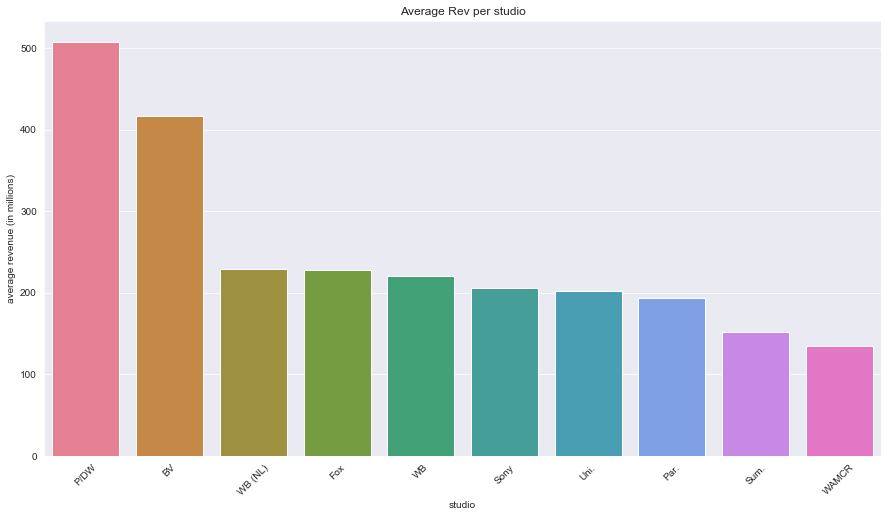

In [41]:
#create average studio revenue, create bar chart
avg_studio_rev = gross_df.groupby('studio')['total_rev'].mean().sort_values(ascending = False)
avg_studio_rev_10 = avg_studio_rev.head(10)
plt.figure(figsize = (15,8))


x = avg_studio_rev_10.index
y = avg_studio_rev_10.values/1000000

bar_plot = sns.barplot(x, y, palette = 'husl')
bar_plot.set(xlabel = 'studio', ylabel = 'average revenue (in millions)',
                                    title = 'Average Rev per studio')
plt.xticks(rotation=45)

The top players here are all to be expected: Dreamworks, Disney, Warner Bros., Fox, Universal, etc. These will be Microsoft's main competition moving forward. It's worth noting again, that Microsoft's resources dwarf these other companies.

### Finally, let's compare the average budgets per year and revenue per year

[Text(0, 0.5, 'Avg_budget (in millions)'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Avg_budget Per Year')]

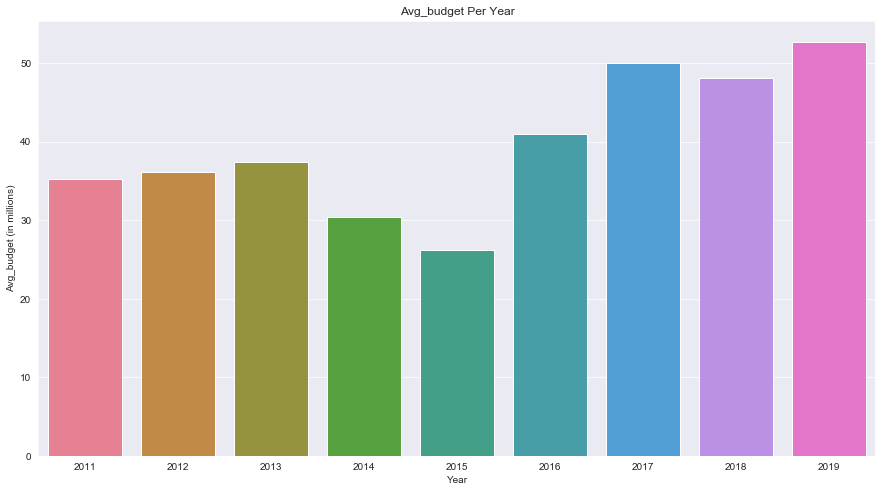

In [42]:
#First, the average budgets per year
budgets_2010s_df1 = budgets_df[(budgets_df['Year'] > 2010) & (budgets_df['Year'] < 2020)]

plt.figure(figsize = (15,8))

#removing 2020 data to align with movies_year_df - also due to covid, many less movies this year
budgets_year_df1 = budgets_2010s_df1.groupby('Year')['production_budget'].mean()

x = budgets_year_df1.index
y = budgets_year_df1.values/1000000

bar_plot = sns.barplot(x, y, palette = 'husl')
bar_plot.set(xlabel = 'Year', ylabel = 'Avg_budget (in millions)',
                                    title = 'Avg_budget Per Year')

In [43]:
df.head()

,movie,start_year,runtime_minutes,genres,averagerating,numvotes,production_budget,domestic_gross,worldwide_gross,profit,ROI,total_rev
608,Jurassic World: Fallen Kingdom,2018,128.0,"[Action, Adventure, Sci-Fi]",6.2,219125,170000000,417719760.0,1305772799,1553492559,9.138192,1.723493e+09
159,Beauty and the Beast,2014,112.0,"[Drama, Fantasy, Romance]",6.4,18100,160000000,504014165.0,1259199706,1603213871,10.020087,1.763214e+09
607,Jurassic World,2015,124.0,"[Action, Adventure, Sci-Fi]",7.0,539338,215000000,652270625.0,1648854864,2086125489,9.702909,2.301125e+09
440,Furious 7,2015,137.0,"[Action, Crime, Thriller]",7.2,335074,190000000,353007020.0,1518722794,1681729814,8.851210,1.871730e+09
184,Black Panther,2018,134.0,"[Action, Adventure, Sci-Fi]",7.3,516148,200000000,700059566.0,1348258224,1848317790,9.241589,2.048318e+09


We have seen a dramatic increase in budgets over the last 4-5 years, with a declining number of movies being made.

Now lets find revenue and profits per year

[Text(0, 0.5, 'Avg_revenue (in millions)'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Avg_revenue Per Year')]

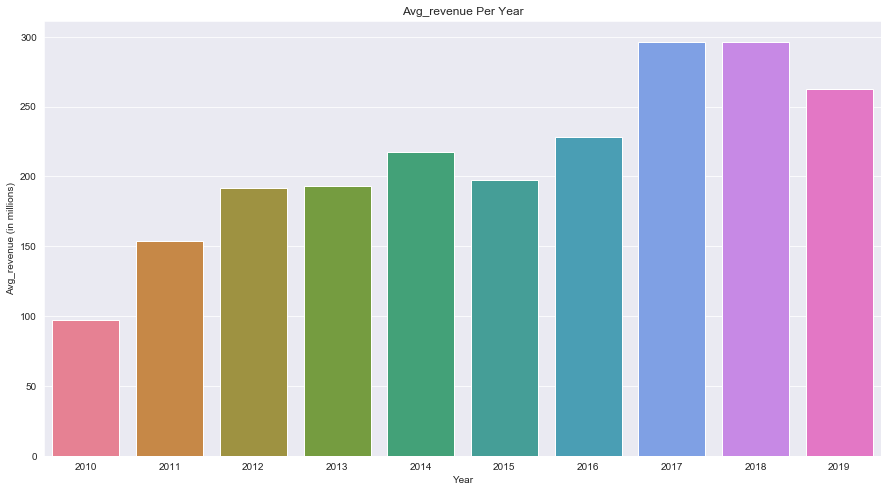

In [44]:
plt.figure(figsize = (15,8))

df = budget_ratings_df.drop(budget_ratings_df[budget_ratings_df['domestic_gross'] == 0].index)
df = df.drop(df[df['domestic_gross'] < 2000].index)

rev_year_df = df.groupby('start_year')['total_rev'].mean()

x = rev_year_df.index
y = rev_year_df.values/1000000

bar_plot = sns.barplot(x, y, palette = 'husl')
bar_plot.set(xlabel = 'Year', ylabel = 'Avg_revenue (in millions)',
                                    title = 'Avg_revenue Per Year')

*Note that these figures do not encompass all movies made over this time. According to [Billboard and Comscore](https://www.billboard.com/articles/news/8547827/2019-global-box-office-revenue-hit-record-425b-despite-4-percent-dip-in-us#:~:text=Global%20box%20office%20revenue%20hit%20a%20record%20%2442.5%20billion%20in,%2411.88%20billion%2C%20according%20to%20Comscore.), global box office revenues in 2019 hit a record 42.5 billion dollars, while North American ticket sales dropped 4% to 11.4 billion from 2018's 11.88 billion.*

[Text(0, 0.5, 'Avg_profit (in millions)'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Avg_profit Per Year')]

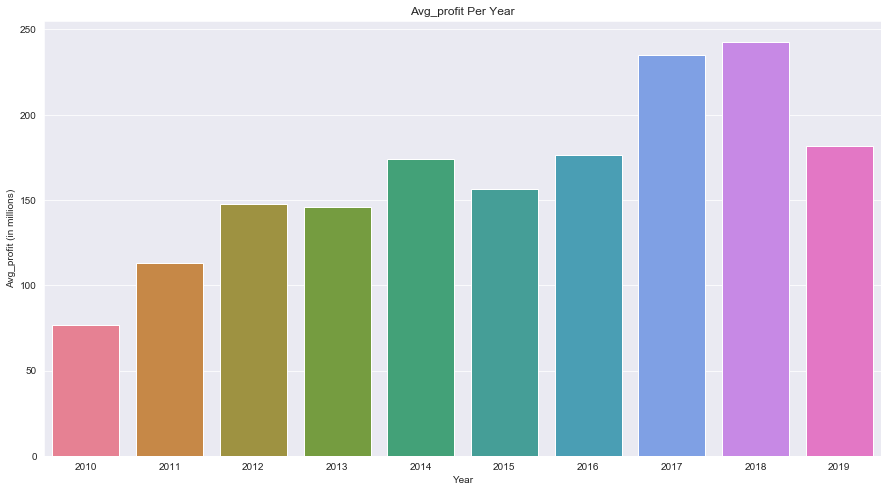

In [45]:
plt.figure(figsize = (15,8))

profit_year_df = df.groupby('start_year')['profit'].mean()

x = profit_year_df.index
y = profit_year_df.values/1000000

bar_plot = sns.barplot(x, y, palette = 'husl')
bar_plot.set(xlabel = 'Year', ylabel = 'Avg_profit (in millions)',
                                    title = 'Avg_profit Per Year')

Profits and revenue have seen a steady increase over time, with a spike in 2017 and 2018. 2019 was likely to continue this trend, with productions like Avengers: Endgame and Star Wars: The Rise of Skywalker, however, we're limited by when this data was pulled from IMDB, leading us to have incomplete 2019 data.

## Conclusion

This analysis led to a number of useful findings:
- Dramas are far and away the most frequent type of movie produced. However, they are not the most lucrative. Adventure, animation, sci-fi, action, and fantasy rake in the most cash.
- We see a strong, positive correlation between budgets and revenues. Movies that tend to spend a lot, also make a lot of money, though this subject could use further analysis
- Average budgets per year are increasing while the number of movies produced a year are slightly decreasing. It's possible that that larger productions and their profitability are discouraging studios from financing smaller movies, that may have equal returns on their investment, but don't earn as much overall.
- There is a clear, strongly positive correlation between revenues and average ratings. This deserves further analysis, but if your movie is rated highly and the production budget was large, chances are the movie is making a lot of money.
- We found a negative correlation between ROI and average rating. This might just be noisy data but it does tell us that ROI has no real connection to ratings, nor does it with how much a movie will earn. The top ROI movies rated significantly worse than the top grossing movies

I offer some recommendations below:

- **Spend money to make money**. As a company as large as Microsoft, to maximize it's returns on the studio, the company should invest in large, franchise-tentpoles that have broad appeal and rake in billions of dollars. Microsoft is the thirs most valuable company in the world, it can afford to take big swings.
- **Consider using your own intellectual property**. The top grossing movies all had major brand name recognition, and were well established. Microsoft owns a vast array of IP in the Xbox department, from Halo to Minecraft to Fallout, part of the company's recent purchase of Bethesda Game Studio.
- **Do not compare your movies' ROI to that of the horror and mystery genre**. Returns between 7-10x are the average for the top grossing movies, which horror films are not apart of. 7-10x are very impressive, but are dwarfed by the 50-100x returns some of the top horror movies earn. These are generally small productions, with an average budget of around 2.5 million dollars. The top grossing movies spend over 200 million dollars. Viral horror movies are outliers and should be considered outside of your purview.
- **Invest in action, adventure, and sci-fi films**. These movies perform the best by a long shot. Popular movies in these genres regularly earn hundreds of millions of dollars, with the most popular eclisping a billion dollars. Microsoft, a company familiar with these genres in its video game business should pursue these types of films as they offer the best chance for hefty earnings.

## Further Analysis

We could glean some addidtional insights from this data by increasing the rigour of our statistical analysis. Some areas I'd like to explore:

- Is the decreasing number of movies being produced a blip or a trend, and are growing production budgets in some way causing this to happen?
- Is there any sort of causation between average ratings and revenues? What other factors lead to high average ratings? Is there a way to engineer movie production to create only high rating movies?
- To what extent does there exist some causation between production budgets and average rating? We found a weak but positive correlation. At what spend threshold do we begin to see diminishing marginal returns?
- Would we see a positive correlation between ROI and ratings if we removed horror and mystery films? To what extent is there a real connection there?
